# Solvent-Environment Dependence of the Excess Chemical Potential and its Computation Scheme Formulated Though Error Minimization
Stefan Hervø-Hansen<sup>a</sup>, Kazuya Okita<sup>a</sup>, Kento Kasahara<sup>a</sup>, and Nobuyuki Matubayasi<sup>a,</sup><br><br>
<sup>a</sup> Division of Chemical Engineering, Graduate School of Engineering Science, Osaka University, Toyonaka, Osaka 560-8531, Japan.<br>
<sup></sup> Correspondence may be addressed to: stefan@cheng.es.osaka-u.ac.jp and nobuyuki@cheng.es.osaka-u.ac.jp.

## Part 3: Analysis

### Introduction
Here we aim to provide a detailed thermodynamic analysis of how urea influence the solvation of polyethylene glycol (PEG). By utilizing molecular dynamics simulations, we can gain atomic insight into the mechanism which underpins the change in excess chemical potential of PEG with the addition of urea. Understanding these effects is crucial for applications in biochemistry and materials science, where PEG and its derivatives are widely used. The following sections detail the methods and materials employed in our simulations and analyses.

### Methods & Materials
Molecular dynamics simulations were conducted using the OpenMM (8.0)[<sup>1</sup>](#fn1) software package. The details of these simulations can be found in the [Part 1 Jupyter notebook](Simulations.ipynb). For the simulation of PEG, a CHARMM-derived force field (C35r) was utilized, which has previously been shown to reproduce the hydrodynamic radii and shape anisotropy of PEG[<sup>2</sup>](#fn2). The PEG force field was combined with the SPC/E force field for water[<sup>3</sup>](#fn3) and a Kirkwood-Buff derived force field for urea[<sup>4</sup>](#fn4).

The isothermal-isobaric ensemble was sampled using a combination of a "Middle" discretization Langevin leap-frog integrator[<sup>5,</sup>](#fn5)[<sup>6</sup>](#fn6) and a Monte Carlo barostat[<sup>7,</sup>](#fn7)[<sup>8</sup>](#fn8). The trajectories were analyzed using MDTraj[<sup>9</sup>](#fn9) for structural properties, while ERmod[<sup>10</sup>](#fn10) was used for the calculation of solvation free energies. The calculation of solvation free energy can be found in the [Part 2 Jupyter notebook](ERmod.ipynb) and the analysis of data can be found in [Part 3 Jupyter notebook](Analysis.ipynb)

### References
1. <span id="fn1"> P. Eastman, et al., OpenMM 8: Molecular Dynamics Simulation with Machine Learning Potentials. J. Phys. Chem. B 128, 109–116 (2023). </span><br>
2. <span id="fn2"> H. Lee, R. M. Venable, A. D. MacKerell Jr., R. W. Pastor, Molecular Dynamics Studies of Polyethylene Oxide and Polyethylene Glycol: Hydrodynamic Radius and Shape Anisotropy. Biophysical Journal 95, 1590–1599 (2008). </span><br>
3. <span id="fn3"> H. J. C. Berendsen, J. R. Grigera, T. P. Straatsma, The missing term in effective pair potentials. J. Phys. Chem. 91, 6269–6271 (1987). </span><br>
4. <span id="fn4"> S. Weerasinghe, P. E. Smith, A Kirkwood−Buff Derived Force Field for Mixtures of Urea and Water. J. Phys. Chem. B 107, 3891–3898 (2003). </span><br>
5. <span id="fn5"> B. Leimkuhler, C. Matthews, Efficient molecular dynamics using geodesic integration and solvent–solute splitting. Proc. R. Soc. A. 472, 20160138 (2016). </span><br>
6. <span id="fn6"> Z. Zhang, X. Liu, K. Yan, M. E. Tuckerman, J. Liu, Unified Efficient Thermostat Scheme for the Canonical Ensemble with Holonomic or Isokinetic Constraints via Molecular Dynamics. J. Phys. Chem. A 123, 6056–6079 (2019). </span><br>
7. <span id="fn7"> K.-H. Chow, D. M. Ferguson, Isothermal-isobaric molecular dynamics simulations with Monte Carlo volume sampling. Computer Physics Communications 91, 283–289 (1995). </span><br>
8. <span id="fn8"> J. Åqvist, P. Wennerström, M. Nervall, S. Bjelic, B. O. Brandsdal, Molecular dynamics simulations of water and biomolecules with a Monte Carlo constant pressure algorithm. Chemical Physics Letters 384, 288–294 (2004). </span><br>
9. <span id="fn9"> R. T. McGibbon, et al., MDTraj: A Modern Open Library for the Analysis of Molecular Dynamics Trajectories. Biophysical Journal 109, 1528–1532 (2015). </span><br>
10. <span id="fn10"> S. Sakuraba, N. Matubayasi, Ermod: Fast and versatile computation software for solvation free energy with approximate theory of solutions. J. Comput. Chem. 35, 1592–1608 (2014). </span><br>

## Import of Python Modules & Auxiliary Functions

In [1]:
#Notebook dependent libs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D      
import matplotlib.patheffects as pe
import mdtraj as md
import scipy.optimize as optimize
from uncertainties import unumpy
import re

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#e69f00", "#56b4e9", "#009e73"])
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
mpl.rcParams["text.usetex"] = True

# Physical constants & useful conversions
kcal_to_kT = 1.688 # Assuming 298.15 K
Na = 6.02214076e23 # Avogadro constant [mol]
liter_to_cubeangstrom = 1e27
nm3_to_l = 1e-24

homedir = !pwd
homedir = homedir[0]
print(homedir)

/data/group1/z44785r/PEO_TMP


### Simulation settings

In [2]:
states = { # State of simulations, (outFreq is steps per frame)
          'conf':{'Nsteps': 500000000, 'OutFreq': 1000}, # 1000 nanoseconds, 500.000 frames
          'sol': {'Nsteps':  25000000, 'OutFreq':  500}, #   50 nanoseconds,  50.000 frames
          'ref': {'Nsteps':  50000000, 'OutFreq':  500}, #  100 nanoseconds, 100.000 frames
         }

nmers = [36] # PEG polymer length
Nparticles = {       # Number of PEG and water molecules. Salt is calculated based on concentration input
    'PEG': 1,
    'Water': 10000,
}
NConfs = 100

urea_reference_concentrations = { 
   0.00: {'P0':    0, 'P1': 378, 'P2': 1472},
   2.00: {'P0':  378, 'P1':   0, 'P2': 1472},
   6.00: {'P0': 1472, 'P1':   0, 'P2':  378},
}

NaCl_reference_concentrations = {
   0.00: {'P0':   0, 'P1': 368, 'P2': 792},
   2.00: {'P0': 368, 'P1':   0, 'P2': 792},
   4.00: {'P0': 792, 'P1':   0, 'P2': 368},
}

## Loading Solvation Free Energies

In [3]:
# Load the Urea results from the disk
slvfe       = np.load('Data/slvfe_PEG_Urea.npy')
slvfe_err   = np.load('Data/slvfe_err_PEG_Urea.npy')
mesh_err    = np.load('Data/mesh_err_PEG_Urea.npy')
self_energy = np.load('Data/self_err_PEG_Urea.npy')

# Load the NaCl results from the disk
slvfe_NaCl       = np.load('Data/slvfe_PEG_NaCl.npy')
slvfe_err_NaCl   = np.load('Data/slvfe_err_PEG_NaCl.npy')
mesh_err_NaCl    = np.load('Data/mesh_err_PEG_NaCl.npy')
self_energy_NaCl = np.load('Data/self_err_PEG_NaCl.npy')

# choose max errors for slefe
max_err = np.maximum.reduce([slvfe_err,mesh_err,self_energy])
max_err_NaCl = np.maximum.reduce([slvfe_err_NaCl,mesh_err_NaCl,self_energy_NaCl])

## Convergence of the change in the excess chemical potential of the solute PEG (Fig 1).

#:	Lower		BAR		Upper
System: Urea, (0 M, 2 M)
10:	-8.02±0.11	-8.08±0.09	-8.05±0.11
20:	-8.02±0.08	-8.05±0.06	-7.99±0.08
30:	-8.10±0.06	-8.06±0.05	-7.95±0.06
40:	-8.06±0.05	-8.07±0.04	-8.01±0.06
50:	-7.98±0.05	-8.01±0.04	-7.98±0.05
60:	-7.93±0.05	-8.02±0.03	-8.05±0.04
70:	-7.92±0.04	-8.05±0.03	-8.09±0.04
80:	-7.93±0.04	-8.06±0.03	-8.11±0.04
90:	-7.95±0.04	-8.05±0.03	-8.08±0.04
100:	-7.99±0.03	-8.06±0.02	-8.06±0.03

System: Urea, (0 M, 6 M)
10:	-25.13±0.16	-25.10±0.20	-24.81±0.14
20:	-25.24±0.10	-25.10±0.12	-24.66±0.10
30:	-25.45±0.08	-25.12±0.10	-24.39±0.09
40:	-25.29±0.07	-25.17±0.08	-24.57±0.07
50:	-25.49±0.06	-25.12±0.07	-24.30±0.07
60:	-25.62±0.06	-25.31±0.06	-24.53±0.06
70:	-25.48±0.05	-25.23±0.06	-24.61±0.06
80:	-25.54±0.05	-25.27±0.05	-24.65±0.05
90:	-25.43±0.05	-25.19±0.05	-24.63±0.05
100:	-25.48±0.04	-25.19±0.05	-24.59±0.05

System: NaCl, (0 M, 2 M)
10:	-5.82±0.42	3.07±0.32	4.17±0.29
20:	-4.70±0.27	4.06±0.27	5.88±0.24
30:	-5.46±0.20	3.42±0.21	5.76±0.20
40:	-6.01±0.17	3.22±0.20	

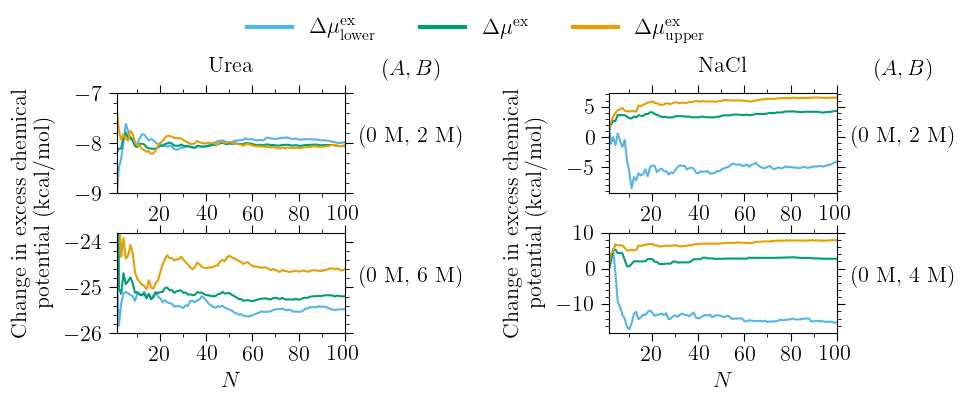

In [4]:
RT = 0.001987 * 298.15 # [kcal/mol]

def BAR_solvation_free_energy(D, state_A, state_B, T=298.15):
    RT = 0.001987 * T # [kcal/mol]
    
    # Asign two states
    dSLVFE_AB = state_A[1] - state_A[0]
    dSLVFE_BA = -(state_B[1] - state_B[0])
    
    # Initializing sum of Fermi-Dirac functions
    sum_f_ij = 0
    sum_f_ji = 0
    
    # Adding Fermi-Dirac function for each slvfe
    for dSLVFE in dSLVFE_AB:
        sum_f_ij += 1/(1+np.exp(-dSLVFE/RT+D))
    for dSLVFE in dSLVFE_BA:
        sum_f_ji += 1/(1+np.exp(dSLVFE/RT-D))
        
    # return squared diff. btw sums of Fermi-Dirac functions
    return (sum_f_ij - sum_f_ji)**2

def BAR_error_solvation_free_energy(D, state_A, state_B, state_A_errs, state_B_errs, T=298.15):
    RT = 0.001987 * T # [kcal/mol]
    
    def F(x): # Fermi-Dirac function
        return 1/(1+np.exp(x))
    def FF(x): # Eq. 21
        return -(1/RT)*F(x)*F(-x)
    
    # Asign two states (Propagation of errors)
    dSLVFE_AB = unumpy.uarray(state_A[1], state_A_errs[1]) - unumpy.uarray(state_A[0], state_A_errs[0])
    dSLVFE_BA = -(unumpy.uarray(state_B[1], state_B_errs[1]) - unumpy.uarray(state_B[0], state_B_errs[0]))
    
    # Calculate the denominator and store the nominators of Eq. 20 
    nominators = []
    denominator = 0
    for slvfe in [*unumpy.nominal_values(dSLVFE_AB), *unumpy.nominal_values(dSLVFE_BA)]:
        value = FF(D-slvfe)
        denominator += value
        nominators.append(value)
        
    # Summuation of the error (Eq. 19)
    BAR_error = 0
    for C, slvfe_err in zip(nominators, [*unumpy.std_devs(dSLVFE_AB), *unumpy.std_devs(dSLVFE_BA)]):
        BAR_error+= (C/denominator)**2 * slvfe_err**2
    return float(np.sqrt(BAR_error))

print('#:\tLower\t\tBAR\t\tUpper\n==================================================')
# Start with a square Figure.
fig = plt.figure(figsize=(12, 3))
gs1 = fig.add_gridspec(nrows=2, ncols=2, left=0.1, right=0.29, bottom=0.1, top=0.9, wspace=0.50, hspace=0.4)
gs2 = fig.add_gridspec(nrows=2, ncols=2, left=0.51, right=0.7, bottom=0.1, top=0.9, wspace=0.05, hspace=0.4)

urea_axes = [fig.add_subplot(gs1[0, 0:]), fig.add_subplot(gs1[1, 0:])]
NaCl_axes = [fig.add_subplot(gs2[0, 0:]), fig.add_subplot(gs2[1, 0:])]

conc_labels = ['(0 M, 2 M)', '(0 M, 6 M)', '(0 M, 2 M)', '(0 M, 4 M)']

# Plot the data
for ctrl, (data,err) in enumerate(zip([slvfe, slvfe_NaCl], [max_err, max_err_NaCl])):
    lower = np.zeros(shape=NConfs)
    bar   = np.zeros(shape=NConfs)
    upper = np.zeros(shape=NConfs)
    
    lower_err = np.zeros(shape=NConfs)
    bar_err   = np.zeros(shape=NConfs)
    upper_err = np.zeros(shape=NConfs)
    k = 0
    
    if ctrl == 0:
        system = 'Urea'
        conc_labels = ['(0 M, 2 M)', '(0 M, 6 M)']
    elif ctrl ==1:
        system = 'NaCl'
        conc_labels = ['(0 M, 2 M)', '(0 M, 4 M)']
    
    i = 0 # Take everything relative to neat water
    for j in range(data.shape[1]):
        if j > i:
            print('System: {}, {}'.format(system, conc_labels[k]))
            for N in range(1,NConfs+1):
                
                # BAR
                a = np.stack((data[i,i,0:N], data[i,j,0:N]), axis=0)
                b = np.stack((data[j,j,0:N], data[j,i,0:N]), axis=0)
                
                a_err = np.stack((err[i,i,0:N], err[i,j,0:N]), axis=0)
                b_err = np.stack((err[j,j,0:N], err[j,i,0:N]), axis=0)
                
                initial_guess = ((data[i,j,:N].mean()-data[i,i,:N].mean())+
                                 (data[j,j,:N].mean()-data[j,i,:N].mean()))/2
                
                result = optimize.minimize(BAR_solvation_free_energy, x0=initial_guess,
                                           args=(a,b,298.15))
                
                bar[N-1] = result.x[0]*RT
                bar_err[N-1] = BAR_error_solvation_free_energy(result.x, a, b, a_err, b_err)
                
                # LOWER
                a = unumpy.uarray(data[j,i,0:N], err[j,i,0:N])
                b = unumpy.uarray(data[j,j,0:N], err[j,j,0:N])
                
                lower[N-1] = unumpy.nominal_values( -(a - b).mean() )
                lower_err[N-1] = unumpy.std_devs( -(a - b).mean() )
                
                # UPPER
                a = unumpy.uarray(data[i,j,0:N], err[i,j,0:N])
                b = unumpy.uarray(data[i,i,0:N], err[i,i,0:N])
                
                upper[N-1] = unumpy.nominal_values( (a - b).mean() )
                upper_err[N-1] = unumpy.std_devs( (a - b).mean() )
                
                if N in np.arange(10,110,10):
                    print('{}:\t{:.2f}±{:.2f}\t{:.2f}±{:.2f}\t{:.2f}±{:.2f}'.format(N,
                                                                                    lower[N-1], lower_err[N-1],
                                                                                    bar[N-1], bar_err[N-1],
                                                                                    upper[N-1], upper_err[N-1]))
                
            x = np.arange(1, NConfs+1)
            if ctrl == 0:
                urea_axes[k].plot(x, lower, color='C1')
                urea_axes[k].plot(x, bar, color='C2')
                urea_axes[k].plot(x, upper, color='C0')
                k+=1
                
            if ctrl == 1:
                l = NaCl_axes[k].plot(x, lower, color='C1')
                b = NaCl_axes[k].plot(x, bar, color='C2')
                u = NaCl_axes[k].plot(x, upper, color='C0')
                k+=1
            print('')

urea_axes[0].text(1.30, 1.17, '$(A, B)$',  transform=urea_axes[0].transAxes, fontsize=16, horizontalalignment='center')
urea_axes[0].text(1.30, 0.5, '(0 M, 2 M)', transform=urea_axes[0].transAxes, fontsize=16, horizontalalignment='center')
urea_axes[1].text(1.30, 0.5, '(0 M, 6 M)', transform=urea_axes[1].transAxes, fontsize=16, horizontalalignment='center')

NaCl_axes[0].text(1.30, 1.17, '$(A, B)$',  transform=NaCl_axes[0].transAxes, fontsize=16, horizontalalignment='center')
NaCl_axes[0].text(1.30, 0.5, '(0 M, 2 M)', transform=NaCl_axes[0].transAxes, fontsize=16, horizontalalignment='center')
NaCl_axes[1].text(1.30, 0.5, '(0 M, 4 M)', transform=NaCl_axes[1].transAxes, fontsize=16, horizontalalignment='center')

urea_axes[0].set_title('Urea', pad=14, fontsize=16)
NaCl_axes[0].set_title('NaCl', pad=14, fontsize=16)

fig.text(0.03, 0.5, f'Change in excess chemical\npotential (kcal/mol)',
         va='center', rotation='vertical', fontsize=16, ha='center')

fig.text(0.44, 0.5, f'Change in excess chemical\npotential (kcal/mol)',
         va='center', rotation='vertical', fontsize=16, ha='center')

urea_axes[1].set_xlabel('$N$', fontsize=16)
NaCl_axes[1].set_xlabel('$N$', fontsize=16)

xtick_major = [0, 20, 40, 60, 80, 100]
xtick_minor = [10, 30, 50, 70, 90]

for ax in [*NaCl_axes, *urea_axes]:
    ax.minorticks_on()
    ax.set_xticks(ticks=xtick_major, minor=False)
    ax.set_xticks(ticks=xtick_minor, minor=True)
    ax.locator_params(axis='y', nbins=4)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis='both', which='major', labelsize=16, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=16, length=3)
    ax.set_xlim(1,100)
    
# Adhoc fixes
urea_axes[0].set_ylim(-9, -7)
urea_axes[1].set_ylim(-26, -23.8)
urea_axes[0].set_yticks(ticks=[-9, -8, -7], minor=False)
NaCl_axes[1].set_ylim(-18, 10)

lower_patch = Line2D([], [], color='C1', lw=3, label='$\Delta\mu^{\mathrm{ex}}_{\mathrm{lower}}$')
BAR_patch   = Line2D([], [], color='C2', lw=3, label='$\Delta\mu^{\mathrm{ex}}$')
upper_patch = Line2D([], [], color='C0', lw=3, label='$\Delta\mu^{\mathrm{ex}}_{\mathrm{upper}}$')

fig.legend(handles=[lower_patch, BAR_patch, upper_patch], loc='lower center', ncol=3, fontsize=16,
           bbox_to_anchor=(0.4, 1.00), frameon=False)

fig.savefig('Figures/slvfe_convergence.pdf', bbox_inches='tight')
fig.savefig('Figures/slvfe_convergence.png', bbox_inches='tight', dpi=600)

## Solvation free energy of PEG as a function of co-solvent concentration as dictated by the inequality  (Fig 2).

0,0 -> 0,1
0,0 -> 0,2
0,0 -> 0,1
0,0 -> 0,2


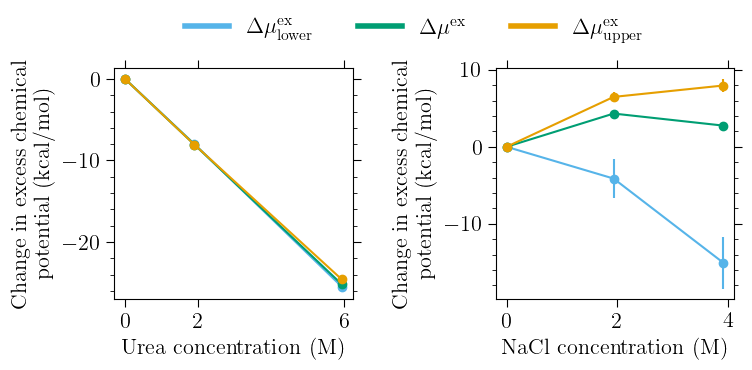

In [5]:
%cd -q $homedir

RT = 0.001987 * 298.15

# Start with a Figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

# Calculate concentrations of Urea
sampled_concentrations_urea = []
for conc in urea_reference_concentrations:
    conc = '{0:.2f}'.format(float(conc))
    f = open('Simulations/PEG36mer/{}/Solute/packmol.in'.format(conc))
    lines = f.readlines()
    f.close()
    Nurea = float(re.findall(r'\b\d+\b',lines[14])[0])
    volume = np.loadtxt('Simulations/PEG36mer/{}/Solute/output.dat'.format(conc), usecols=(4), unpack=True)
    sampled_concentrations_urea.append(Nurea / (volume.mean() * Na * nm3_to_l))

# Load the sampled NaCl concentration data
sampled_concentrations_NaCl = np.load('Data/NaCl_sampled_concentrations.npy')

for ctrl, (ax, slvfe_set,err) in enumerate(zip([urea_axes,NaCl_axes],[slvfe,slvfe_NaCl],[max_err, max_err_NaCl])):
    if ctrl == 0:
        concentrations = sampled_concentrations_urea
    elif ctrl == 1:
        concentrations = sampled_concentrations_NaCl
        
    lower = [0]
    bar   = [0]
    upper = [0]
    
    lower_err = [0]
    bar_err   = [0]
    upper_err = [0]
    
    i = 0 # Take everything relative to neat water
    for j in range(slvfe_set.shape[1]):
        if j > i:
            print('{},{} -> {},{}'.format(i,i,i,j))
            # BAR
            a = np.stack((slvfe_set[i,i], slvfe_set[i,j]), axis=0)
            b = np.stack((slvfe_set[j,j], slvfe_set[j,i]), axis=0)
            
            a_err = np.stack((err[i,i], err[i,j]), axis=0)
            b_err = np.stack((err[j,j], err[j,i]), axis=0)
            
            initial_guess = ((slvfe_set[i,j].mean()-slvfe_set[i,i].mean())+
                             (slvfe_set[j,j].mean()-slvfe_set[j,i].mean()))/2
            
            result = optimize.minimize(BAR_solvation_free_energy, x0=initial_guess,
                                       args=(a,b,298.15))
            
            bar.append(result.x[0]*RT)
            bar_err.append(BAR_error_solvation_free_energy(result.x, a, b, a_err, b_err))
            
            # LOWER
            a = unumpy.uarray(slvfe_set[j,i], err[j,i])
            b = unumpy.uarray(slvfe_set[j,j], err[j,j])
            lower.append(unumpy.nominal_values( -(a - b).mean() ))
            solvent_err = unumpy.std_devs( -(a - b).mean() )
            solute_err = 1.96*unumpy.nominal_values( -(a - b) ).std() / np.sqrt(a.shape[0])
            lower_err.append(np.sqrt(solvent_err**2 + solute_err**2))
            
            # UPPER
            a = unumpy.uarray(slvfe_set[i,j], err[i,j])
            b = unumpy.uarray(slvfe_set[i,i], err[i,i])
            upper.append(unumpy.nominal_values( (a - b).mean() ))
            solute_err = 1.96*unumpy.nominal_values( (a - b) ).std() / np.sqrt(a.shape[0])
            upper_err.append(np.sqrt(solvent_err**2 + solute_err**2))
    
    axes[ctrl].errorbar(concentrations, lower, yerr=lower_err, marker='o', markersize=6, color='C1')
    axes[ctrl].errorbar(concentrations, bar,   yerr=bar_err,   marker='o', markersize=6, color='C2')
    axes[ctrl].errorbar(concentrations, upper, yerr=upper_err, marker='o', markersize=6, color='C0')

# Beautification
for ax in axes:
    ax.set_ylabel('Change in excess chemical\npotential (kcal/mol)', fontsize=16, labelpad=5)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=16, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=16, length=3)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')

axes[0].set_xlabel('Urea concentration (M)', fontsize=16)
axes[1].set_xlabel('NaCl concentration (M)', fontsize=16)

xtick_major = [0, 2, 6]
ytick_minor = [-2, -4, -6, -8, -12, -14, -16, -18, -20, -22, -24, -26]
axes[0].set_xticks(ticks=xtick_major, minor=False)
axes[0].set_xticks(ticks=[], minor=True)
axes[0].set_yticks(ticks=ytick_minor, minor=True)

xtick_major = [0, 2, 4]
ytick_minor = [8, 6, 4, 2, -2, -4, -6, -8, -12, -14, -16, -18]
axes[1].set_xticks(ticks=xtick_major, minor=False)
axes[1].set_xticks(ticks=[], minor=True)
axes[1].set_yticks(ticks=ytick_minor, minor=True)

lower_patch = Line2D([], [], color='C1', lw=4, label='$\Delta\mu^{\mathrm{ex}}_{\mathrm{lower}}$')
BAR_patch   = Line2D([], [], color='C2', lw=4, label='$\Delta\mu^{\mathrm{ex}}$')
upper_patch = Line2D([], [], color='C0', lw=4, label='$\Delta\mu^{\mathrm{ex}}_{\mathrm{upper}}$')

fig.legend(handles=[lower_patch, BAR_patch, upper_patch], loc='lower center', ncol=3, fontsize=16,
           bbox_to_anchor=(0.5, 0.9), frameon=False)

fig.subplots_adjust(wspace=0.6)
fig.savefig('Figures/slvfe_concentration_inequality.pdf', bbox_inches='tight')
fig.savefig('Figures/slvfe_concentration_inequality.png', bbox_inches='tight', dpi=600)

## Probability distribution function of the radius of gyration of the PEG solute upon variation of the solvent condition (Fig 3).

In [6]:
%cd -q $homedir
for nmer in nmers:
    nmerdir = 'PEG{}mer'.format(nmer)
    for urea_reference in urea_reference_concentrations.items():
        C = '{0:.2f}'.format(urea_reference[0])
        %cd -q $homedir/Simulations/$nmerdir/$C/Solute
            
        traj = md.load_xtc('trajectory_dry.xtc', top=homedir+'/PDB_files/PEO-36-mer.pdb')
        PEG_atoms = traj.topology.select('(resname PGH) or (resname PGM) or (resname PGT)')
        traj_PEG = traj.atom_slice(PEG_atoms)
        traj_PEG = traj_PEG[traj_PEG.n_frames//2::]
        rg = md.compute_rg(traj_PEG)
        np.save('{}/Data/Rg_PEG36_Urea_{}.npy'.format(homedir,C), rg)

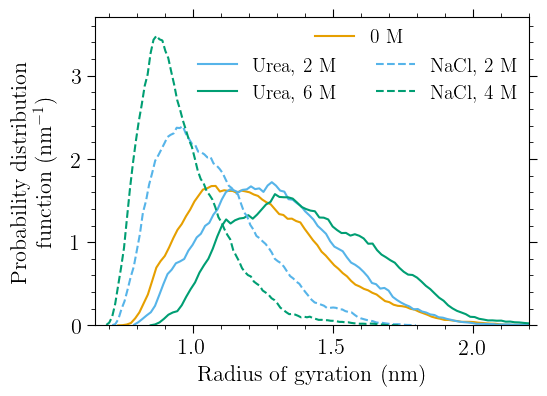

In [7]:
%cd -q $homedir
fig, ax = plt.subplots(figsize=(5.6, 4))

Nblocks = 4
Nbins = 100
lines = []

sampled_concs = [0,2,6,0,2,4]

for i, conc in enumerate([*urea_reference_concentrations.keys(), *NaCl_reference_concentrations.keys()]):
    if i == 0:
        Rg_data = np.load('Data/Rg_PEG36_NaCl_0.00.npy')
        linestyle = 'solid'
        label = '0 M'
    elif i == 3:
        continue
    else:
        if i > 2:
            cosolvent = 'NaCl'
            linestyle = 'dashed'
        else:
            cosolvent = 'Urea'
            linestyle = 'solid'
        label = '{0}, {1:.0f} M'.format(cosolvent, sampled_concs[i])
        fname = 'Rg_PEG36_{0:}_{1:.2f}.npy'.format(cosolvent, conc)
        Rg_data = np.load('Data/'+fname)
        
    Rg_data = Rg_data.reshape((Nblocks, len(Rg_data)//Nblocks))
    densities = np.zeros(shape=(Nblocks,Nbins))
    
    for j, rg in enumerate(Rg_data):
        density, edges = np.histogram(rg, bins=Nbins, density=True, range=(Rg_data.min(), Rg_data.max()))
        densities[j,:] = density
    
    centers = (edges[:-1]+edges[1:])/2
    
    line = ax.plot(centers, densities.mean(axis=0), label=label, linestyle=linestyle, color='C{}'.format(i%3))
    lines.append(line[0])
    
legend = ax.legend(handles=lines[1:], frameon=False, ncols=2, loc=(0.22, 0.70), fontsize=14)
ax.add_artist(legend)
ax.legend(handles=lines[0:1], frameon=False, loc=(0.49, 0.88), fontsize=14)
ax.set_xlabel('Radius of gyration (nm)', fontsize=16)
ax.set_ylabel('Probability distribution\nfunction ($\mathrm{nm}^{-1}$)', fontsize=16, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=16, length=6)
ax.tick_params(axis='both', which='minor', labelsize=16, length=3)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

xtick_major = [1.0, 1.5, 2.0]
xtick_minor = [0.6, 0.7, 0.8, 0.9, 1.1, 1.2, 1.3, 1.4, 1.6, 1.7, 1.8, 1.9, 2.1, 2.2]

ax.minorticks_on()
ax.set_xticks(ticks=xtick_major, minor=False)
ax.set_xticks(ticks=xtick_minor, minor=True)
ax.locator_params(axis='y', nbins=6)

ax.set_ylim(0, 3.7)
ax.set_xlim(0.65, 2.2)

fig.savefig('Figures/structural_changes.pdf', bbox_inches='tight')
fig.savefig('Figures/structural_changes.png', bbox_inches='tight', dpi=600)

## Probability distribution functions of the change in the solvation free energy upon variation of the solvent condition (Fig 4).

0,0 -> 0,1
0,0 -> 0,2
0,0 -> 0,1
0,0 -> 0,2


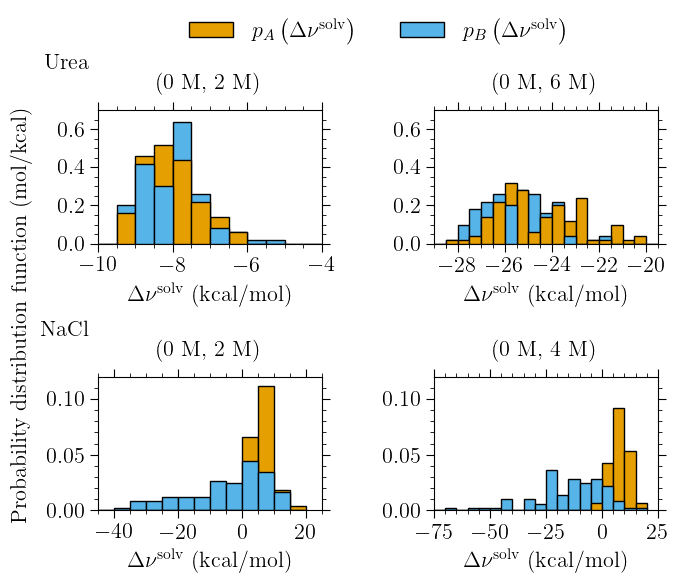

In [8]:
def gauss(x,mu,sigma):
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))

# Start with a square Figure.
fig = plt.figure(figsize=(7, 5))
gs1 = fig.add_gridspec(2, 2, left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=1.0)

# Create the Axes.
urea_axes = [fig.add_subplot(gs1[0, 0]), fig.add_subplot(gs1[0, 1])]
NaCl_axes = [fig.add_subplot(gs1[1, 0]), fig.add_subplot(gs1[1, 1])]


for k, (ax, slvfe_set) in enumerate(zip([urea_axes,NaCl_axes],[slvfe,slvfe_NaCl])):
    ctrl = 0
    i = 0 # Take everything relative to neat water
    for j in range(slvfe_set.shape[1]):
        if j > i:
            print('{},{} -> {},{}'.format(i,i,i,j))
            a = np.stack((slvfe_set[i,i], slvfe_set[i,j]), axis=0)
            b = np.stack((slvfe_set[j,j], slvfe_set[j,i]), axis=0)
            dSLVFE_AB = a[1] - a[0]
            dSLVFE_BA = -(b[1] - b[0])
            if np.isnan(np.sum(dSLVFE_AB)) or np.isnan(np.sum(dSLVFE_BA)):
                continue
            lower = min([min(dSLVFE_AB), min(dSLVFE_BA)])
            upper = max([max(dSLVFE_AB), max(dSLVFE_BA)])
            if k == 0:
                bins = np.arange(-30, -3, 0.5)
            else:
                bins = np.arange(-75, 25, 5)
            ax[ctrl].hist(dSLVFE_AB, density=True, bins=bins, ec='black')
            hist = ax[ctrl].hist(dSLVFE_BA, density=True, bins=bins, ec='black')
            
            for bars in zip(*ax[ctrl].containers):
                order = np.argsort(np.argsort([b.get_height() for b in bars]))
                for bar, bar_order in zip(bars, order):
                    bar.set_zorder(2 + len(ax[ctrl].containers) - bar_order)
            ctrl+=1

# Beautification
fig.text(-0.01, 0.49, s='Probability distribution function (mol/kcal)', horizontalalignment='center',
         verticalalignment='center', rotation='vertical', fontsize=16)

titles = ['(0 M, 2 M)', '(0 M, 6 M)', '(0 M, 2 M)', '(0 M, 4 M)']
for i, ax in enumerate([*urea_axes, *NaCl_axes]):
    ax.minorticks_on()
    ax.locator_params(axis='y', nbins=4)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis='both', which='major', labelsize=16, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=16, length=3)
    ax.set_xlabel(r'$\Delta\nu^{\mathrm{solv}}$'f' (kcal/mol)', fontsize=16)
    ax.set_title(titles[i], fontsize=16, pad=15)
    

urea_axes[1].set_xticks(ticks=[-28, -26, -24, -22, -20], minor=False)
urea_axes[1].set_xticks(ticks=[-29, -28.5, -28.5, -27.5, -27, -26.5,
                               -25.5, -25, -24.5, -24, -23.5, -23,
                               -22.5, -22, -21.5, -21, -20.5, -19.5], minor=True)
urea_axes[0].set_xlim(-10, -4)
urea_axes[1].set_xlim(-29, -19.5)

NaCl_axes[0].set_xticks(ticks=[-40, -20, 0, 20], minor=False)
NaCl_axes[0].set_xticks(ticks=[-45, -35, -30, -25, -15, -10, -5, 0, 5, 10, 15, 25], minor=True)
NaCl_axes[1].set_xticks(ticks=[-75, -50, -25, 0, 25], minor=False)
NaCl_axes[0].set_xlim(-45, 25)
NaCl_axes[1].set_xlim(-75, 25)

for ax in NaCl_axes:
    ax.set_ylim(0, 0.12)
    
for ax in urea_axes:
    ax.set_ylim(0, 0.7)
    
urea_axes[0].text(-0.04, 1.3, 'Urea', transform=urea_axes[0].transAxes, fontsize=16, horizontalalignment='right')
NaCl_axes[0].text(-0.04, 1.3, 'NaCl', transform=NaCl_axes[0].transAxes, fontsize=16, horizontalalignment='right')

PA = mpatches.Patch(facecolor='C0', edgecolor='black', lw=1, label=r'$p_{A}\left(\Delta\nu^{\mathrm{solv}}\right)$')
PB = mpatches.Patch(facecolor='C1', edgecolor='black', lw=1, label=r'$p_{B}\left(\Delta\nu^{\mathrm{solv}}\right)$')

fig.legend(handles=[PA, PB], loc='lower center', ncol=2, fontsize=16, bbox_to_anchor=(0.5, 0.99), frameon=False)

fig.savefig('Figures/histograms_v2.pdf', bbox_inches='tight')
fig.savefig('Figures/histograms_v2.png', bbox_inches='tight', dpi=600)

## Relative entropy from transformations (Unused)

System:			Gaussian overlap error	Discrete distribution overlap error
Urea (0 M, 2 M):	1.28E-02		3.70E-02
Urea (0 M, 6 M):	5.26E-02		7.03E-02
NaCl (0 M, 2 M):	1.73E-01		1.26E-01
NaCl (0 M, 4 M):	2.41E-01		2.20E-01


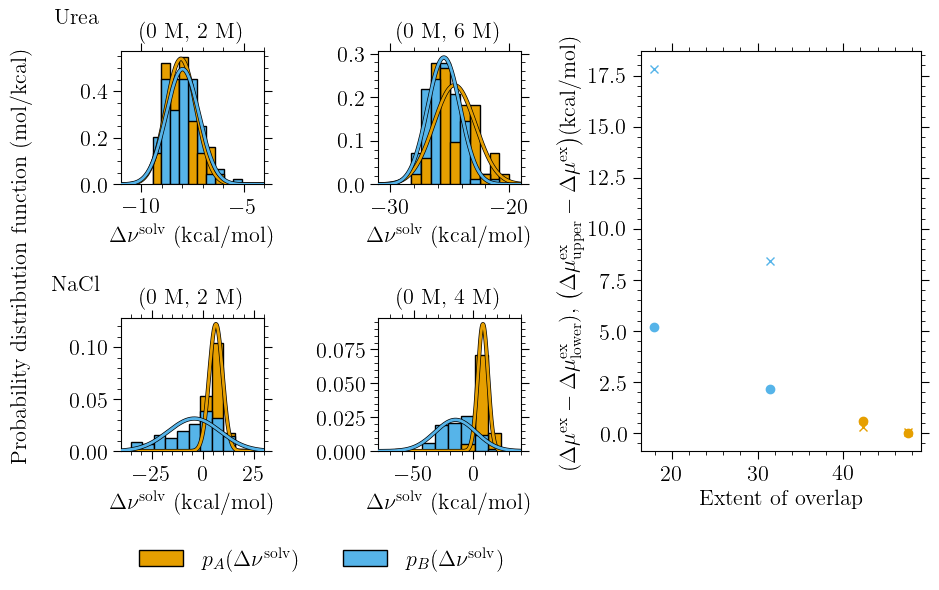

In [9]:
def gauss(x,mu,sigma):
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))

# Start with a square Figure.
fig = plt.figure(figsize=(10, 5))
gs1 = fig.add_gridspec(2, 2, left=0.1, right=0.5, bottom=0.1, top=0.9, wspace=0.8, hspace=1.0)
gs2 = fig.add_gridspec(2, 2, left=0.62, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

# Create the Axes.
urea_axes = [fig.add_subplot(gs1[0, 0]), fig.add_subplot(gs1[0, 1])]
NaCl_axes = [fig.add_subplot(gs1[1, 0]), fig.add_subplot(gs1[1, 1])]
err_ax = fig.add_subplot(gs2[0:,0:])

for ax, slvfe_set in zip([urea_axes,NaCl_axes],[slvfe,slvfe_NaCl]):
    ctrl = 0
    i = 0
    for j in range(slvfe_set.shape[1]):
        if j > i:
            a = np.stack((slvfe_set[i,i], slvfe_set[i,j]), axis=0)
            b = np.stack((slvfe_set[j,j], slvfe_set[j,i]), axis=0)
            dSLVFE_AB = a[1] - a[0]
            dSLVFE_BA = -(b[1] - b[0])
            if np.isnan(np.sum(dSLVFE_AB)) or np.isnan(np.sum(dSLVFE_BA)):
                continue
            
            lower = min([min(dSLVFE_AB), min(dSLVFE_BA)])
            upper = max([max(dSLVFE_AB), max(dSLVFE_BA)])
            ax[ctrl].hist(dSLVFE_AB, density=True, bins=10, range=(lower, upper), ec='black')
            hist = ax[ctrl].hist(dSLVFE_BA, density=True, bins=10, range=(lower, upper), ec='black')

            for bars in zip(*ax[ctrl].containers):
                order = np.argsort(np.argsort([b.get_height() for b in bars]))
                for bar, bar_order in zip(bars, order):
                    bar.set_zorder(2 + len(ax[ctrl].containers) - bar_order)
            
            d = np.zeros(shape=(2,10000000))
            for k, energies in enumerate([dSLVFE_AB,dSLVFE_BA]):
                mean = energies.mean()
                sigma = energies.std()
                x = np.arange(-100, 100, 0.01)
                if k == 0:
                    color = 'C0'
                else:
                    color = 'C1'
                ax[ctrl].plot(x,gauss(x,mean,sigma), color=color, zorder=1e10, linewidth=2,path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
            ctrl+=1

systems = ['Urea (0 M, 2 M)', 'Urea (0 M, 6 M)', 'NaCl (0 M, 2 M)', 'NaCl (0 M, 4 M)']

ctrl=0
print('System:\t\t\tGaussian overlap error\tDiscrete distribution overlap error')
for k, data_set in enumerate([slvfe,slvfe_NaCl]):
    y1 = []
    y2 = []
    x = []
    i = 0 # Take everything relative to neat water
    for j in range(data_set.shape[1]):
        if j > i:
            a = np.stack((data_set[i,i], data_set[i,j]), axis=0)
            b = np.stack((data_set[j,j], data_set[j,i]), axis=0)
            dSLVFE_AB = a[1] - a[0]
            dSLVFE_BA = -(b[1] - b[0])
            if np.isnan(np.sum(dSLVFE_AB)) or np.isnan(np.sum(dSLVFE_BA)):
                continue
                
            initial_guess = ((data_set[i,j].mean()-data_set[i,i].mean())+
                             (data_set[j,j].mean()-data_set[j,i].mean()))/2
                
            result = optimize.minimize(BAR_solvation_free_energy, x0=initial_guess,
                                           args=(a,b,298.15))
                
            bar = result.x[0]*RT
            
            d = np.zeros(shape=(2,10000000))
            for h, energies in enumerate([dSLVFE_AB, dSLVFE_BA]):
                mean = energies.mean()
                sigma = energies.std()
                xs = np.arange(-5000, 5000, 0.001)
                density = gauss(xs, mean, sigma)
                d[h,:] = density * 0.001
            
            overlap_err_term = 0
            overlap = 0
            for densities in d.T:
                if densities[0] == 0 and densities[1] == 0:
                    continue
                overlap += densities[0]*densities[1] / (densities[0]+densities[1])
            E1 = RT**2/(NConfs*overlap) - RT**2/NConfs - RT**2/NConfs
            E1 = np.sqrt(E1)*1.96 # 95% errors
            
            
            lower = min([min(dSLVFE_AB), min(dSLVFE_BA)])
            upper = max([max(dSLVFE_AB), max(dSLVFE_BA)])
            A = np.histogram(dSLVFE_AB, density=False, bins=10, range=(lower, upper))
            B = np.histogram(dSLVFE_BA, density=False, bins=10, range=(lower, upper))
            
            overlap = 0
            for pA, pB in zip(A[0], B[0]):
                if pA == 0 and pB == 0:
                    continue
                overlap += (pA*pB/(pA+pB))
            E2 = RT**2/overlap - RT**2/NConfs - RT**2/NConfs
            E2 = np.sqrt(E2)*1.96 # 95% errors
            print('{}:\t{:.2E}\t\t{:.2E}'.format(systems[ctrl], E1, E2))
            
            y1.append(abs(dSLVFE_AB.mean()-bar))
            y2.append(abs(dSLVFE_BA.mean()-bar))
            x.append(overlap)
            ctrl+=1
    
    if k == 0:
        color = 'C0'
    else:
        color = 'C1'
    err_ax.plot(x,y1, linestyle='None', marker='o', color=color)
    err_ax.plot(x,y2, linestyle='None', marker='x', color=color)
    
# Beautification
fig.text(0.0, 0.49, s='Probability distribution function (mol/kcal)', horizontalalignment='center',
         verticalalignment='center', rotation='vertical', fontsize=16)
    
urea_axes[0].set_xlim(-11, -4)
urea_axes[1].set_xlim(-31, -19)

NaCl_axes[0].set_xlim(-40, 30)
NaCl_axes[1].set_xlim(-80, 40)

titles = ['(0 M, 2 M)', '(0 M, 6 M)', '(0 M, 2 M)', '(0 M, 4 M)']
for i, ax in enumerate([*urea_axes, *NaCl_axes]):
    ax.minorticks_on()
    ax.locator_params(axis='y', nbins=4)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis='both', which='major', labelsize=16, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=16, length=3)
    ax.set_xlabel(r'$\Delta\nu^{\mathrm{solv}}$ (kcal/mol)', fontsize=16)
    ax.set_title(titles[i], fontsize=16, pad=10)
    
urea_axes[0].text(-0.15, 1.2, 'Urea', transform=urea_axes[0].transAxes, fontsize=16, horizontalalignment='right')
NaCl_axes[0].text(-0.15, 1.2, 'NaCl', transform=NaCl_axes[0].transAxes, fontsize=16, horizontalalignment='right')
    
err_ax.set_ylabel(r'$\left( \Delta\mu^{\mathrm{ex}} - \Delta\mu^{\mathrm{ex}}_{\mathrm{lower}} \right)$, '
                  r'$\left( \Delta\mu^{\mathrm{ex}}_{\mathrm{upper}} - \Delta\mu^{\mathrm{ex}} \right)$'
                  r'(kcal/mol)', fontsize=16)

err_ax.set_xlabel('Extent of overlap', fontsize=16)
err_ax.minorticks_on()
err_ax.yaxis.set_ticks_position('both')
err_ax.xaxis.set_ticks_position('both')
err_ax.tick_params(axis='both', which='major', labelsize=16, length=6)
err_ax.tick_params(axis='both', which='minor', labelsize=16, length=3)

PA = mpatches.Patch(facecolor='C0', edgecolor='black', lw=1, label=r'$p_A(\Delta\nu^{\mathrm{solv}})$')
PB = mpatches.Patch(facecolor='C1', edgecolor='black', lw=1, label=r'$p_B(\Delta\nu^{\mathrm{solv}})$')

fig.legend(handles=[PA, PB], loc='lower center', ncol=2, fontsize=16, bbox_to_anchor=(0.3, -0.18), frameon=False)

## Graphical abstract 

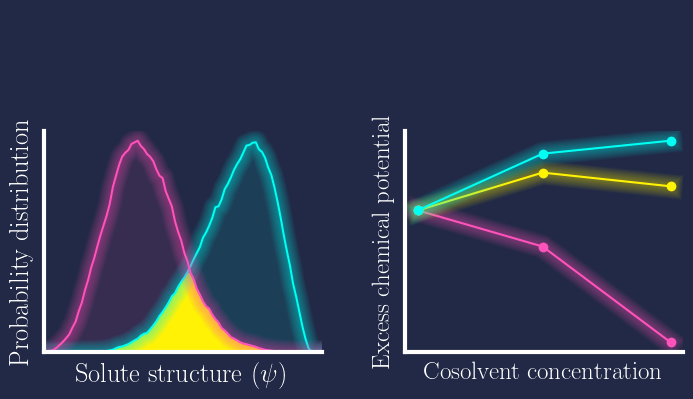

In [10]:
with plt.rc_context({'text.color': 'white',
                     'axes.labelcolor': 'white',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'axes.edgecolor': 'white',
                     'figure.facecolor': '#212946',
                     'axes.facecolor': '#212946',
                     'axes.linewidth': 3,
                     'font.family': 'Times New Roman',
                     'text.usetex': True,
                     'figure.figsize': (8.25, 4.45),
                     }):
    
    fig = plt.figure(figsize=(8.25, 4.45))
    dummy_ax = plt.subplot2grid((3, 2), (0, 0), colspan=2, fig=fig)
    ax2 = plt.subplot2grid((3, 2), (1, 0), rowspan=2, fig=fig)
    ax3 = plt.subplot2grid((3, 2), (1, 1), rowspan=2, fig=fig)
    axes = [ax2,ax3]
    
    colors = [
        '#01FFF4',  # teal/cyan
        '#FE53BB',  # pink
        '#FFF205',  # yellow d
    ]
    
    n_lines = 15
    diff_linewidth = 1.05
    alpha_value = 0.03
    
    # Load data
    SASA_NaCl = np.load('Data/SASA_PEG36_NaCl_4.00.npy')
    SASA_wat  = np.load('Data/SASA_PEG36_NaCl_0.00.npy')
    
    data = []
    
    for i, SASA in enumerate([SASA_wat, SASA_NaCl]):
        y,edges = np.histogram(SASA, bins=100, density=True, range=(15,34))
        centers = 0.5*(edges[1:]+ edges[:-1])
        data.append(y)
        axes[0].plot(centers,y, linestyle='solid', color=colors[i])
        for n in range(1, n_lines+1):
            axes[0].plot(centers,y, linestyle='solid', linewidth=2+(diff_linewidth*n), alpha=alpha_value, 
                         color=colors[i])
        axes[0].fill_between(x=centers, y1=y,y2=0, color=colors[i],alpha=0.1)
    
    axes[0].fill_between(centers, y1=np.minimum(data[0], data[1]), y2=0,
                         facecolor=colors[2], alpha=1.0)
    
    axes[0].set_xlabel('Solute structure ($\psi$)', fontsize=19)
    axes[0].set_ylabel('Probability distribution', fontsize=19)
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    axes[0].set_xticklabels([])
    axes[0].set_yticklabels([])
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_xlim(16, 33)
    axes[0].set_ylim(0, 0.19)
    
    lower = [0]
    bar   = [0]
    upper = [0]
    
    i = 0 # Take everything relative to neat water
    for j in range(slvfe_NaCl.shape[1]):
        if j > i:
            # BAR
            a = np.stack((slvfe_NaCl[i,i], slvfe_NaCl[i,j]), axis=0)
            b = np.stack((slvfe_NaCl[j,j], slvfe_NaCl[j,i]), axis=0)
            initial_guess = ((slvfe_NaCl[i,j].mean()-slvfe_NaCl[i,i].mean())+
                             (slvfe_NaCl[j,j].mean()-slvfe_NaCl[j,i].mean()))/2
            result = optimize.minimize(BAR_solvation_free_energy, x0=initial_guess, args=(a,b,298.15))
            bar.append(result.x[0]*RT)
            
            # LOWER
            a = slvfe_NaCl[j,i]; b = slvfe_NaCl[j,j]
            lower.append( -(a - b).mean() )
            
            # UPPER
            a = slvfe_set[i,j]; b = slvfe_set[i,i]
            upper.append( (a - b).mean() )
            
    for y, color in zip([lower, bar, upper], [colors[1], colors[2], colors[0]]):
        for n in range(1, n_lines+1):
            axes[1].plot(concentrations, y, linestyle='solid', linewidth=2+(diff_linewidth*n),
                         alpha=alpha_value, color=color)
        axes[1].plot(concentrations, y, marker='o', markersize=6, color=color)
    
    axes[1].set_xlabel('Cosolvent concentration', fontsize=18)
    axes[1].set_ylabel('Excess chemical potential', fontsize=18)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].set_xticklabels([])
    axes[1].set_yticklabels([])
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    
    dummy_ax.spines['top'].set_visible(False)
    dummy_ax.spines['right'].set_visible(False)
    dummy_ax.spines['left'].set_visible(False)
    dummy_ax.spines['bottom'].set_visible(False)
    dummy_ax.set_xticklabels([])
    dummy_ax.set_yticklabels([])
    dummy_ax.set_xticks([])
    dummy_ax.set_yticks([])
    
    fig.subplots_adjust(wspace=0.3)
    
    fig.savefig('Figures/Graphical_abstract.pdf', bbox_inches='tight')
    fig.savefig('Figures/Graphical_abstract.png', bbox_inches='tight', dpi=600)